# Particle Swarm Optimisation for Graph Neural Network Architecture Search

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import reddit
from torch_geometric.datasets import reddit2
from torch_geometric.datasets import imdb
from torch_geometric.datasets import zinc

from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

This GNN can handle different types of convolutional layers, and both node and graph classification.
The build_conv_model method determines which type of convolutional layer to use for the given task, a graph convolutional network for node classificationtion (GCNConv) and a graph isomorphism network for graph classification (GINConv).
This model is made of 3 covolution layers followed by mean pooling in the case of graph classification, followed by 2 fully connected layers.
Sing our goal here is classification, we use a negative log-likelihood loss function.

List of the changeable hyperparameters:

    - hidden_dim (dimmension of hidden layers)

    - number of convs layers

    - number of lns layers (normalisation layers)
    

In [16]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, output_dim, task='node', hidden_num = 2, hidden_dim = 32):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList() #convolution operations
        self.lns = nn.ModuleList() #normalisation operations
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        # adding convolution an normalisation layers
        for l in range(hidden_num):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))
            # self.lns.append(nn.LayerNorm(hidden_dim))

        # self.lns.append(nn.LayerNorm(hidden_dim))


        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim)) # adding 2 linear layers 
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = hidden_num

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        # create different types of GCNConv according to the problem to solve
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        # x = feature matrix = number of nodes * number of node feature dimensions,
        # edge_index = list of the edges in the graph,
        # batch = batch of a graph
        x, edge_index, batch = data.x, data.edge_index, data.batch

        if data.num_node_features == 0: #if there is no feature, use a constant feature
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers): # ,create num_layers convolution layers
            # print("test")
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
            # if not i == self.num_layers - 1:
            #     x = self.lns[i](x)

        if self.task == 'graph': # if it is a graph classification task, do a pooling
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

pyg_nn.GCNConv and pyg_nn.GINConv are instances of MessagePassing, They define a single layer of graph convolution, which can be decomposed into:
- Message computation
- Aggregation
- Update
- Pooling

Training the model with forward propagation and back propagation. 
For node classification, we split nodes into training and testing sets.
Same thing for graph classification, we use 80% of the graphs for training and the remainder for testing.

In [17]:
def train(dataset, task, hidden_num , hidden_dim, lr=0.01):
    trigger = 0
    prev_acc = 0.0

    if task == 'graph':
        data_size = len(dataset)
        # split data  into traning and testing set
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = DataLoader(dataset, batch_size=64, shuffle=True)
        loader = test_loader

    # build model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = GNNStack(max(dataset.num_node_features, 1), dataset.num_classes, task=task, hidden_num=hidden_num, hidden_dim=hidden_dim)
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr)
    
    # train for 200 epochs
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            # get the prediction and the excpeted label
            embedding, pred = model(batch)
            # pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
            
        total_loss /= len(loader.dataset)

        
        test_acc = test(test_loader, model)
        # print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
        #     epoch, total_loss, test_acc))
        # writer.add_scalar("test accuracy", test_acc, epoch)

        if test_acc <= prev_acc:
            trigger += 1

        if trigger >= 10:
            # print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
            # epoch, total_loss, test_acc) + " | hidden_num = " + str(hidden_num) + ", hidden_dim = " + str(hidden_dim) + ", lr = " + str(lr))
            break
        prev_acc = test_acc
        
    return model, total_loss, test_acc

For the CiteSeer/Cora node classification task, there is only one graph, so we use masking to determine validation and test set. In graph classification, a subset of graphs is considered as a validation/test graph

In [18]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad(): # avoid gradient computing for faster results
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
     
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

///////////////////
///////////////////
///////////////////
///////////////////

In [19]:
import copy
import random

class Particle:
    def __init__(self):
        self.hidden_dim = random.randint(2, 50)
        self.hidden_num = random.randint(2, 10)
        self.lr = round(random.uniform(0.0100, 0.0001), 4)
        # self.parameters = NN_parameters()
        self.cognitiveCoef = 1 # can be changed
        self.socialCoef = 1 # can be changed
        self.informantList = list()
        self.informants_best_err = -1
        self.best_err = -1
        self.best_wb = []
        self.informants_best = [self.hidden_num, self.hidden_dim, self.lr]
        self.err = -1  # Current error (set to -1 at start
        self.velocity_hidden_num = random.random()
        self.velocity_hidden_dim = random.random()
        self.velocity_lr = round(random.uniform(0.0100, 0.0001), 4)

    def setInformants(self, swarm, informantNum, index):
        banned_index = []
        i = 0
        swarm_buffer = copy.deepcopy(swarm)
        banned_index.append(index)
        while i < informantNum:
            informant_chosen = np.random.randint(0, len(swarm_buffer))
            if informant_chosen in banned_index:
                continue
            self.informantList.append(swarm[informant_chosen])
            banned_index.append(informant_chosen)
            i += 1

    def set_informant_best(self):
        for informer in self.informantList:
            if informer.best_err < self.informants_best_err or self.informants_best_err == -1:
                self.informants_best_err = informer.best_err
                self.informants_best = informer.best_wb
    
    def check_error(self, loss):
        self.err = 0
        if self.err < self.best_err or self.best_err == -1:
            self.best_err = self.err
            self.best_wb = [self.hidden_num, self.hidden_dim, self.lr]

    def update_velocity(self):
        inertia_weight = 1

        # Change the velocity values for hidden_num
        r1 = random.random()
        r2 = random.random()

        vel_cog = self.cognitiveCoef * r1 * (self.best_wb[0] - self.hidden_num)
        vel_soc = self.socialCoef * r2 * (self.informants_best[0] - self.hidden_num)
        self.velocity_hidden_num = inertia_weight * self.velocity_hidden_num + vel_soc + vel_cog

        #Change the velocity values for hidden_dim
        r1 = random.random()
        r2 = random.random()

        vel_cog = self.cognitiveCoef * r1 * (self.best_wb[1] - self.hidden_dim)
        vel_soc = self.socialCoef * r2 * (self.informants_best[1] - self.hidden_dim)
        self.velocity_hidden_dim = inertia_weight * self.velocity_hidden_dim + vel_soc + vel_cog

        #Change the velocity values for lr
        r1 = random.random()
        r2 = random.random()

        vel_cog = self.cognitiveCoef * r1 * (self.best_wb[2] - self.lr)
        vel_soc = self.socialCoef * r2 * (self.informants_best[2] - self.lr)
        self.velocity_lr = inertia_weight * self.velocity_lr + vel_soc + vel_cog

    # Update the hidden num and dim
    def change_wb(self):
        self.hidden_num = int(round(self.velocity_hidden_num + self.hidden_num))
        self.hidden_dim = int(round(self.velocity_hidden_dim + self.hidden_dim))
        self.lr = self.velocity_lr + self.lr
        if self.hidden_num < 2:
            self.hidden_num = 2
        if self.hidden_dim < 2:
            self.hidden_dim = 2
        if self.lr <= 0:
            self.lr = 0.0001
        elif self.lr > 1:
            self.lr = 1.0000


In [20]:
class Swarm:
    def __init__(self, informants_number, particle_number):
        self.best_loss = 1000
        self.best_accuracy = 0
        self.informants_number = informants_number
        self.swarm = list()
        self.particle_number = particle_number

        for i in range(self.particle_number):
            new_particle = Particle()
            self.swarm.append(new_particle)
        
        for j in range(len(self.swarm)):
            self.swarm[j].setInformants(self.swarm, self.informants_number, j)
        

    def Optimise(self):
        #Run Optimisation
        for p in range(0,self.particle_number):
            # Find best informants
            self.swarm[p].set_informant_best()
            # Update velocities
            self.swarm[p].update_velocity()
            # Apply velocities to weights and biases
            self.swarm[p].change_wb()

    # For every particle, creates a neural network from the particles weights and biases. And than calculate the output values of the neural network
    def train_epoch(self, dataset, task):
        self.best_loss = 1000
        self.best_accuracy = 0
        for p in range(0, int(self.particle_number)):
            # print("Particle num = " + str(p))
            # informants_best[0] = hidden_num
            # informants_best[1] = hidden_dim
            # informants_best[2] = lr

            model, loss, accuracy = train(dataset, task, int(round(self.swarm[p].hidden_num)), int(round(self.swarm[p].hidden_dim)), self.swarm[p].lr)
            # model, loss = simple_train(dataset, task, int(round(self.swarm[p].hidden_num)), int(round(self.swarm[p].hidden_dim)), self.swarm[p].lr)
            
            if loss < self.best_loss:
                self.best_loss = loss
                self.best_accuracy = accuracy

            # self.total_accuracy += accuracy
            # self.total_loss += loss
                
            self.swarm[p].check_error(loss)
        
        # self.ret_accuracy = self.total_accuracy / int(self.particle_number)
        # self.ret_loss = self.total_loss / int(self.particle_number)
        
        # print("return values = loss: " + str(self.best_loss) + ", accuracy: " + str(self.best_accuracy))
        return self.best_loss, self.best_accuracy

    # Return the best error of the entire swarn
    def get_best(self):
        swarm_best_err = -1
        for p in self.swarm:
            if p.best_err < swarm_best_err or swarm_best_err == -1:
                swarm_best_err = p.best_err

        return swarm_best_err

    def plot(self, y):
        plt.plot(y)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0,100])
        plt.show()

In [21]:
dataset = Planetoid(root='/tmp/cora', name='cora')
dataset = dataset.shuffle()
task = 'node'

data = {'epoch':  [],
        'loss': [],
        'accuracy': []
        }

df = pd.DataFrame(data)


# 5 informants, 50 particles
swarm = Swarm(3, 15)
for i in range(100):
    print("Epoch = " + str(i))
    loss, accuracy = swarm.train_epoch(dataset, task)
    print("loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy}
    df = df.append(new_row, ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()
print(df)

Epoch = 0
loss: 0.6345996260643005, accuracy: 0.697
Epoch = 1


KeyboardInterrupt: 

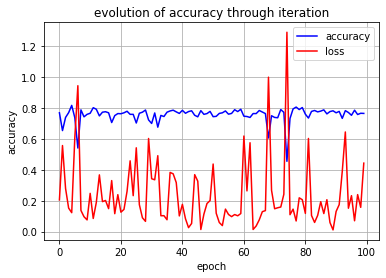

In [ ]:
plt.plot(df['epoch'], df['accuracy'], label = "accuracy", color="blue")
plt.plot(df['epoch'], df['loss'], label = "loss", color="red")
plt.title('evolution of accuracy through iteration')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [ ]:
plt.savefig("../figures/cora_node_3_15")

In [ ]:
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')
dataset = dataset.shuffle()
task = 'graph'


# dataset = Planetoid(root='/tmp/cora', name='cora')
# dataset = dataset.shuffle()
# task = 'node'

data = {'epoch':  [],
        'loss': [],
        'accuracy': []
        }

df = pd.DataFrame(data)


# 5 informants, 50 particles
swarm = Swarm(3, 15)
for i in range(100):
    print("Epoch = " + str(i))
    loss, accuracy = swarm.train_epoch(dataset, task)
    print("loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy}
    df = df.append(new_row, ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()
print(df)

Extracting /tmp/PROTEINS/PROTEINS/PROTEINS.zip
Processing...
Done!


Epoch = 0
loss: 0.6003047479672379, accuracy: 0.6188340807174888
Epoch = 1
loss: 0.5908751884872994, accuracy: 0.6412556053811659
Epoch = 2
loss: 0.5979864409800326, accuracy: 0.6278026905829597
Epoch = 3
loss: 0.6015850578131301, accuracy: 0.5919282511210763
Epoch = 4


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


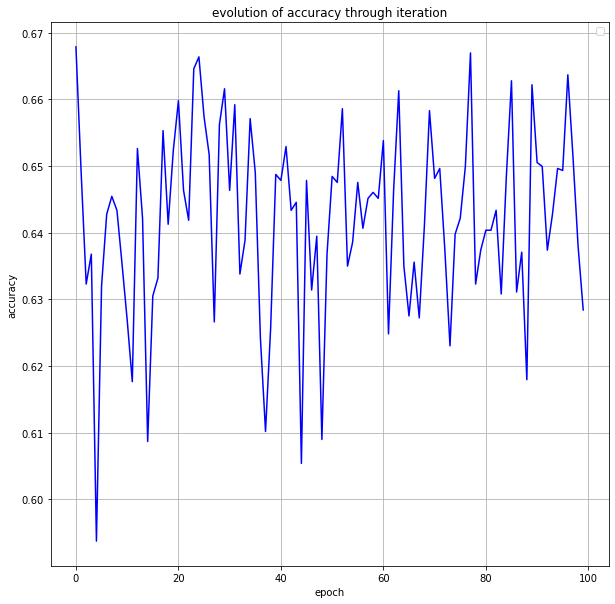

In [ ]:
plt.plot(df['epoch'], df['accuracy'], color="blue")
plt.title('evolution of accuracy through iteration')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [ ]:
plt.savefig("../figures/proteins_graph_3_15")

In [ ]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
task = 'graph'

data = {'epoch':  [],
        'loss': [],
        'accuracy': []
        }

df = pd.DataFrame(data)


# 5 informants, 50 particles
swarm = Swarm(3, 15)
for i in range(100):
    print("Epoch = " + str(i))
    loss, accuracy = swarm.train_epoch(dataset, task)
    print("loss: " + str(loss) + ", accuracy: " + str(accuracy))
    new_row = {'epoch':i, 'loss':loss, 'accuracy':accuracy}
    df = df.append(new_row, ignore_index=True)
    swarm.Optimise()
    best_err = swarm.get_best()
print(df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


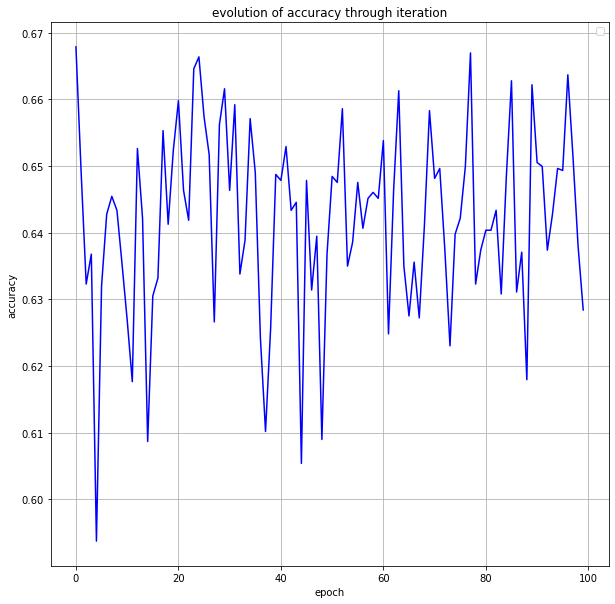

In [ ]:
plt.plot(df['epoch'], df['accuracy'], color="blue")
plt.title('evolution of accuracy through iteration')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [ ]:
plt.savefig("../figures/enzymes_graph_3_15")